# Align oligo to read (minimap2, ont, kmer6)

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import numpy as np

font = 14
plt.rcParams.update({'font.size': 14})

In [2]:
ref_path = '/Users/yan/Desktop/eurecom_code/data/motif/error-rate/ref-seq-8-32.fa'

ref = []
with open(ref_path) as file_in:
    for line in file_in:
        if line.startswith('>'):
            continue
        else:
            ref.append(line.strip())

ref[0]

'TACAGGACTACAGGGGACCGGAAACTACAACGCAGATTACAACCTCAGTTTTCCGGTCCCCTGTAGTCCTGTAA'

In [3]:
def check_cigar_flatten(s):
    #ref_id is 1-index, pos is 1-index of the ref
    _cigar = s['cigar']
    _ref_id = s['ref_id']
    _ref_seq = ref[_ref_id - 1]
    _read_seq = s['read_seq']
    ref_pos = s['pos'] - 1
    read_pos = 0

    cigar_num = []
    cigar_char = []
    num = 0

    for i in _cigar:
        if i.isdigit():
            num = num*10 + int(i)
        else:
            cigar_num.append(num)
            cigar_char.append(i)
            num = 0
    
    res = ''
    for i in range(len(cigar_char)):
        if cigar_char[i] == 'M':
            for j in range(cigar_num[i]):
                if _read_seq[read_pos] == _ref_seq[ref_pos]:
                    res += 'M'
                else:
                    res += 'X'
                read_pos += 1
                ref_pos += 1
        else:
            res += (cigar_char[i] * cigar_num[i])
            if cigar_char[i] == 'I':
                read_pos += cigar_num[i]
            elif cigar_char[i] == 'D':
                ref_pos += cigar_num[i]
            else: #clip
                read_pos += cigar_num[i]
    return res

In [4]:
path = '/Users/yan/Desktop/eurecom_code/data/motif/error-rate/guppy/'
sam_path = path + 'minimap2-8-32-cov100-final.sam'
read_path = path + 'guppy-mapped-cov100.string'

# path = '/Users/yan/Desktop/eurecom_code/data/motif/error-rate/bonito-ssp/'
# sam_path = path + '200707_SSP_formatted-mapped-mn.sam'
# read_path = path + '200707_SSP_formatted.fasta'

# path = '/Users/yan/Desktop/eurecom_code/data/motif/error-rate/bonito/'
# sam_path = path + '200707_ori_bonito_formatted-mapped-mn.sam'
# read_path = path + '200707_ori_bonito_formatted.fasta'

# path = '/Users/yan/Desktop/eurecom_code/data/motif/error-rate/guppy/'
# sam_path = path + 'guppy-mapped-mn.sam'
# read_path = path + '200707_ori_guppy.fasta'

In [5]:
## Load the reads '.fasta'
read = []
cnt = 1
with open(read_path) as file_in:
    for line in file_in:
        read.append([str(cnt), line.strip()])
        cnt += 1

read = pd.DataFrame(read)
read = read.rename(columns={0: "read_id", 1: "read_seq"})
read.head(10)

,read_id,read_seq
0,1,TGTACTTCGTTCAGTTACGTATTGCTCATGGGAGTGGAAACGAAAC...
1,2,TTGCCTTCGTTCGGTTACGTATTGCTTACAGGACTACAGGGGACCG...
2,3,CTGTACTTCAGATTGCCTTGTTGTACTTCGTTCCAGTTACGTATTA...
3,4,CGATATTACTTCGTTCAGTTACGTATTGCTAAGCATCCCATGGTAA...
4,5,ATTGTACTTCGTTCAGTTTATCAGACATACTTCCGTTCAGTTTTGT...
5,6,CACCTGGTGATTCGGTTGCGGCTCATTGTAACAAGCATCCGTGTAG...
6,7,GTTGTACTTCGTTCAGTTACGTATTGCTACGACGGGGGTAAACATT...
7,8,ATTACTTCGTTCAGCATTGTGCTTCGTTCAGTTACGTATTGCTATC...
8,9,TGTACTTCGTTCAGAAAAATTTCAACGTACTTCGTTCAATTTAAGC...
9,10,AATTGTACTTCGTTCAGTTACGTATTGCTTCGGGAATCATCTTCAT...


In [6]:
## Load the sam file '.sam'
sam = pd.read_csv(sam_path)
sam['read_id'] = sam['read_id'].astype(str)
sam = pd.merge(sam, read, how='left', left_on=['read_id'], right_on=['read_id'])
sam['len'] = sam['read_seq'].str.len()
sam.head(10)

,read_id,pos,oligo,score,FLAG,oligo_id,MAPQ,CIGAR,NM,read_seq,len
0,1,193,>5PMotif_7MoSS5->3PMotif_30MoSS5,116,0,222,20,64M10S,NM:i:2,TGTACTTCGTTCAGTTACGTATTGCTCATGGGAGTGGAAACGAAAC...,290
1,2,27,>5PMotif_1MoSS5->3PMotif_31MoSS5,104,0,31,10,55M19S,NM:i:1,TTGCCTTCGTTCGGTTACGTATTGCTTACAGGACTACAGGGGACCG...,175
2,2,116,>5PMotif_7MoSS5->3PMotif_7MoSS5,116,0,199,21,58M16S,NM:i:0,TTGCCTTCGTTCGGTTACGTATTGCTTACAGGACTACAGGGGACCG...,175
3,3,187,>5PMotif_2MoSS5->3PMotif_13MoSS5,124,0,45,19,21M1I47M5S,NM:i:2,CTGTACTTCAGATTGCCTTGTTGTACTTCGTTCCAGTTACGTATTA...,340
4,4,31,>5PMotif_5MoSS5->3PMotif_11MoSS5,112,0,139,21,25M2D35M14S,NM:i:2,CGATATTACTTCGTTCAGTTACGTATTGCTAAGCATCCCATGGTAA...,307
5,4,125,>5PMotif_8MoSS5->3PMotif_11MoSS5,120,0,235,52,60M14S,NM:i:0,CGATATTACTTCGTTCAGTTACGTATTGCTAAGCATCCCATGGTAA...,307
6,4,245,>5PMotif_8MoSS5->3PMotif_3MoSS5,122,0,227,53,61M13S,NM:i:0,CGATATTACTTCGTTCAGTTACGTATTGCTAAGCATCCCATGGTAA...,307
7,5,54,>5PMotif_4MoSS5->3PMotif_14MoSS5,118,0,110,12,62M12S,NM:i:1,ATTGTACTTCGTTCAGTTTATCAGACATACTTCCGTTCAGTTTTGT...,115
8,6,135,>5PMotif_7MoSS5->3PMotif_6MoSS5,112,0,198,10,35M1I27M11S,NM:i:2,CACCTGGTGATTCGGTTGCGGCTCATTGTAACAAGCATCCGTGTAG...,196
9,7,29,>5PMotif_2MoSS5->3PMotif_17MoSS5,112,0,49,12,1S59M14S,NM:i:1,GTTGTACTTCGTTCAGTTACGTATTGCTACGACGGGGGTAAACATT...,186


In [7]:
ref_cnt = sam['oligo_id'].value_counts().rename_axis('unique_values').reset_index(name='counts')
print("the median coverage is " + str(ref_cnt['counts'].median()))
print("the mean coverage is " + str(ref_cnt['counts'].mean()))
sam = sam.groupby('read_id').head(1).reset_index(drop=True)
print('nb. of aligned reads: ' + str(len(sam)))
sam = sam[sam['len']>50]
print('nb. of aligned reads with good read length (>50bp): ' + str(len(sam)))

the median coverage is 24.0
the mean coverage is 30.046875
nb. of aligned reads: 6576
nb. of aligned reads with good read length (>50bp): 6576


new logic, map to ref and pos by pos
- M/X
- insertion : 23M10I30M ->  one insertion at pos 23
- deletion:  23M10D -> 10 deletion from pos 23 to 33
- softclipping: 
-- insertion (mode 1)
-- softclipping (mode 2)
-- not track (mode 3)
- not align from ref pos 0:
-- deletion (mode 1, 3)
-- softclipping (mode 2)
- length is shorter than ref, but cigar not track 
-- deletion (mode 1, 3)
-- softclipping (mode 2)

In [46]:
ref[221]

'AGGGTTAACATAAGTGCACACGGTCTACAACGCAGATTACAACCTCAGTTAACTTCGGAATGTACACTTTGGCG'

In [35]:
# mode = 3
# def check_cigar_on_ref(s):
#     cigar = s['CIGAR']
#     ref_start = s['pos']
#     read_seq = s['read_seq']
#     ref_id = s['oligo_id']
#     ref_seq = ref[ref_id - 1]
    
#     ref_pos = ref_start - 1
#     read_pos = 0

#     cigar_num = []
#     cigar_char = []
#     num = 0

#     for i in cigar:
#         if i.isdigit():
#             num = num * 10 + int(i)
#         else:
#             cigar_num.append(num)
#             cigar_char.append(i)
#             num = 0

#     res = ''
#     valid_len = 0

#     # if not align from beginning --> deletion
#     if ref_pos != 0:
#         valid_len += ref_pos
#         if ( (mode == 1) or (mode == 3)):
#             res += ('D' * ref_pos)
#         elif (mode == 2):
#             res += ('S' * ref_pos)


#     for i in range(len(cigar_char)):
#         if cigar_char[i] == 'S':
#             if (mode == 1):
#                 res += 'I'
#             elif (mode == 2):
#                 res += 'S'
#             read_pos += cigar_num[i]
#         elif cigar_char[i] == 'M':
#             valid_len += cigar_num[i]
#             for j in range(cigar_num[i]):
#                 if read_seq[read_pos] == ref_seq[ref_pos]:
#                     res += 'M'
#                 else:
#                     res += 'X'
#                 read_pos += 1
#                 ref_pos += 1
#         elif cigar_char[i] == 'I':
#             res += 'I'
#             read_pos += cigar_num[i]
#         elif cigar_char[i] == 'D':
#             valid_len += cigar_num[i]
#             res += (cigar_char[i] * cigar_num[i])
#             ref_pos += cigar_num[i]

#     if valid_len < 74:
#         if ((mode == 1) or (mode == 3)):
#             res += ('D' * (74 - valid_len))
#         elif (mode == 2):
#             res += ('S' * (74 - valid_len))
#         ref_pos += cigar_num[i]

#     return res

In [8]:
mode = 3
def check_cigar_on_ref(s):
#     print(s)
    cigar = s['CIGAR']
    read_start = s['pos']
    read_seq = s['read_seq']
    ref_id = s['oligo_id']
    ref_seq = ref[ref_id - 1]

    read_pos = read_start - 1
    ref_pos = 0

    cigar_num = []
    cigar_char = []
    num = 0

    for i in cigar:
        if i.isdigit():
            num = num * 10 + int(i)
        else:
            cigar_num.append(num)
            cigar_char.append(i)
            num = 0

    res = ''
    for i in range(len(cigar_char)):
        if cigar_char[i] == 'S':
            res += ('S' * cigar_num[i])
            ref_pos += cigar_num[i]
        elif cigar_char[i] == 'M':
            for j in range(cigar_num[i]):
                if read_seq[read_pos] == ref_seq[ref_pos]:
                    res += 'M'
                else:
                    res += 'X'
                read_pos += 1
                ref_pos += 1
        elif cigar_char[i] == 'I':
            res += ('D' * cigar_num[i])
            ref_pos += cigar_num[i]
        elif cigar_char[i] == 'D':
            res += 'I'
            read_pos += cigar_num[i]

    return res

In [9]:
# sam['flatten'] = sam.apply(check_cigar_flatten, axis=1)
sam['flatten'] = sam.apply(check_cigar_on_ref, axis=1)
sam['len'] = sam['flatten'].str.len()
max_len = sam['len'].max()
max_len

80

In [10]:
flattened = sam['flatten'].tolist()
flattened[0]

'MMMMMMMMMMXMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMXMMMMMMMMMMMMMMMMMMMMMMSSSSSSSSSS'

In [11]:
max_len = 76
mis_rate = []
i_rate = []
d_rate = []
other_rate = []

for i in range(max_len):
    nb_m = 0
    nb_mis = 0
    nb_i = 0
    nb_d = 0
    nb_o = 0
    
    for j in range(len(flattened)):
        if i < len(flattened[j]):
            if flattened[j][i] == 'M':
                nb_m += 1
            elif flattened[j][i] == 'I':
                nb_i += 1
            elif flattened[j][i] == 'D':
                nb_d += 1
            elif flattened[j][i] == 'X':
                nb_mis += 1
            else:
                nb_o += 1
                
#     nb_total = nb_m + nb_mis + nb_i + nb_d + nb_o
    nb_total = len(sam)
    mis_rate.append(nb_mis/nb_total)
    i_rate.append(nb_i/nb_total)
    d_rate.append(nb_d/nb_total)
    other_rate.append(nb_o/nb_total)
    
pos = list(range(max_len))

In [12]:
print("the substitution rate is " + str(sum(mis_rate) / len(mis_rate))) 
print("the insertion rate is " + str(sum(i_rate) / len(i_rate))) 
print("the deletion rate is " + str(sum(d_rate) / len(d_rate))) 

the substitution rate is 0.01141111217825586
the insertion rate is 0.007817502241003974
the deletion rate is 0.007485353438340377


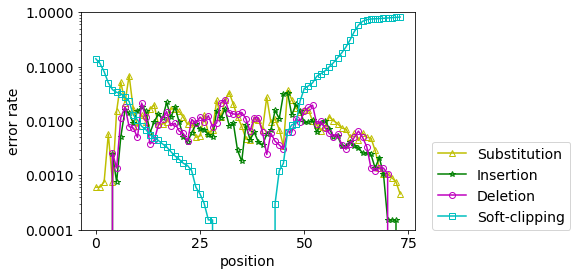

In [13]:
font = 14
plt.rcParams.update({'font.size': 14})

plt.plot(pos[0:74], mis_rate[0:74], 'y^-', markerfacecolor='none', label='Substitution')
plt.plot(pos[0:74], i_rate[0:74], 'g*-', markerfacecolor='none', label='Insertion')
plt.plot(pos[0:74], d_rate[0:74], 'mo-', markerfacecolor='none', label='Deletion')
plt.plot(pos[0:74], other_rate[0:74], 'cs-', markerfacecolor='none', label='Soft-clipping')

plt.xlabel('position')
plt.ylabel('error rate')
plt.xticks(np.arange(0, 76, 25))
# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0, prop={'size': font})

plt.yscale('log') # some out of the figure, because error rate is 0, and log0 is infinity
plt.ylim((0.0001, 1))

ax = plt.gca()
# ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())

# plt.tight_layout()

plt.savefig(path + '/multi-align-error-rate.pdf', bbox_inches='tight')
plt.show()

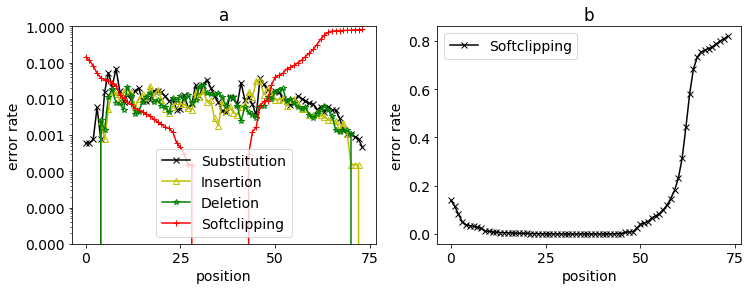

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
plt.rcParams.update({'font.size': 14})

ax1.plot(pos[0:74], mis_rate[0:74], 'kx-', markerfacecolor='none', label='Substitution')
ax1.plot(pos[0:74], i_rate[0:74], 'y^-', markerfacecolor='none', label='Insertion')
ax1.plot(pos[0:74], d_rate[0:74], 'g*-', markerfacecolor='none', label='Deletion')
ax1.plot(pos[0:74], other_rate[0:74], 'r+-', markerfacecolor='none', label='Softclipping')

ax1.set(xlabel='position', ylabel='error rate', xticks=np.arange(0, 76, 25))
ax1.set_title('a')
ax1.legend()
ax1.set_yscale('log')
ax1.set_ylim(0.000001, 1)
ax1.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.yaxis.set_minor_formatter(mticker.NullFormatter())

ax2.plot(pos[0:74], other_rate[0:74], 'kx-', markerfacecolor='none', label='Softclipping')

ax2.set(xlabel='position', ylabel='error rate', xticks=np.arange(0, 76, 25))
ax2.set_title('b')
ax2.legend()

# plt.savefig(path + '/mode-'+ str(mode) + '-multi-panel-error-raw.pdf')
plt.show()

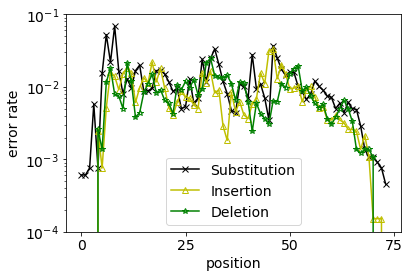

In [17]:
## raw error rate in log scale
plt.rcParams.update({'font.size': 14})

plt.plot(pos[0:74], mis_rate[0:74], 'kx-', markerfacecolor='none', label='Substitution')
plt.plot(pos[0:74], i_rate[0:74], 'y^-', markerfacecolor='none', label='Insertion')
plt.plot(pos[0:74], d_rate[0:74], 'g*-', markerfacecolor='none', label='Deletion')

plt.xlabel('position')
plt.ylabel('error rate')
plt.xticks(np.arange(0, 76, 25))
plt.legend()

plt.yscale('log') # some out of the figure, because error rate is 0, and log0 is infinity
plt.ylim((0.0001, 0.1))

# plt.savefig(path + '/mode-'+ str(mode) + '-multi-panel-error-raw.pdf')
plt.show()


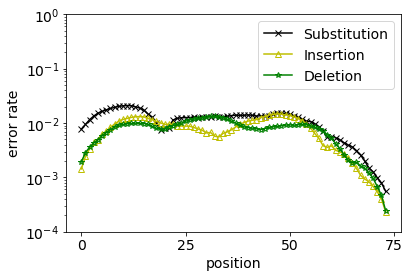

In [86]:
# 使用Savitzky-Golay 滤波器后得到平滑图线
from scipy.signal import savgol_filter

# window_length：窗口长度，该值需为正奇整数。例如：此处取值27，越大越平滑
# k值：polyorder为对窗口内的数据点进行k阶多项式拟合，k的值需要小于window_length。例如：此处取值3。越小越平滑

mis_rate_smooth = savgol_filter(mis_rate, 27, 3, mode= 'nearest')
i_rate_smooth = savgol_filter(i_rate, 27, 3, mode= 'nearest')
d_rate_smooth = savgol_filter(d_rate, 27, 3, mode= 'nearest')

plt.rcParams.update({'font.size': 14})

plt.plot(pos[0:74], mis_rate_smooth[0:74], 'kx-', markerfacecolor='none', label='Substitution')
plt.plot(pos[0:74], i_rate_smooth[0:74], 'y^-', markerfacecolor='none', label='Insertion')
plt.plot(pos[0:74], d_rate_smooth[0:74], 'g*-', markerfacecolor='none', label='Deletion')

plt.xlabel('position')
plt.ylabel('error rate')
plt.xticks(np.arange(0, 76, 25))
plt.legend()
plt.yscale('log')
           
plt.ylim((0.0001, 1))

plt.savefig(path + '/multi-align-fit-log.pdf')
plt.show()

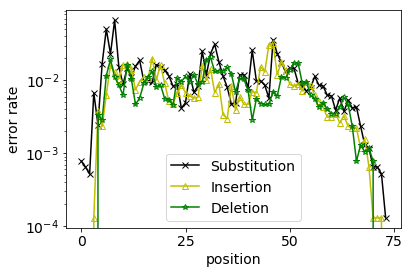

In [87]:
# ## raw error rate
# plt.rcParams.update({'font.size': 14})

# plt.plot(pos[0:60], mis_rate[0:60], 'kx-', markerfacecolor='none', label='Substitution')
# plt.plot(pos[0:60], i_rate[0:60], 'y^-', markerfacecolor='none', label='Insertion')
# plt.plot(pos[0:60], d_rate[0:60], 'g*-', markerfacecolor='none', label='Deletion')

# plt.xlabel('position')
# plt.ylabel('error rate')
# plt.xticks(np.arange(0, 76, 25))
# plt.legend()

# # plt.savefig(path + '/mode-'+ str(mode) + '-multi-panel-error-raw.pdf')
# plt.show()


## raw error rate in log scale
plt.plot(pos[0:74], mis_rate[0:74], 'kx-', markerfacecolor='none', label='Substitution')
plt.plot(pos[0:74], i_rate[0:74], 'y^-', markerfacecolor='none', label='Insertion')
plt.plot(pos[0:74], d_rate[0:74], 'g*-', markerfacecolor='none', label='Deletion')

plt.xlabel('position')
plt.ylabel('error rate')
plt.xticks(np.arange(0, 76, 25))
plt.legend()

plt.yscale('log') # some out of the figure, because error rate is 0, and log0 is infinity
# plt.ylim((0.000000000001, 1))

# plt.savefig(path + '/mode-'+ str(mode) + '-multi-panel-error-log.pdf')
plt.savefig(path + '/multi-align-log.pdf')
plt.show()


# ## smoothed raw error rate
# from scipy.signal import savgol_filter
# mis_rate_smooth = savgol_filter(mis_rate, 27, 3, mode= 'nearest')
# i_rate_smooth = savgol_filter(i_rate, 27, 3, mode= 'nearest')
# d_rate_smooth = savgol_filter(d_rate, 27, 3, mode= 'nearest')

# plt.plot(pos[0:74], mis_rate_smooth[0:74], 'kx-', markerfacecolor='none', label='Substitution')
# plt.plot(pos[0:74], i_rate_smooth[0:74], 'y^-', markerfacecolor='none', label='Insertion')
# plt.plot(pos[0:74], d_rate_smooth[0:74], 'g*-', markerfacecolor='none', label='Deletion')

# plt.xlabel('position')
# plt.ylabel('error rate')
# plt.xticks(np.arange(0, 76, 25))
# plt.legend()

## plt.savefig(path + '/mode-'+ str(mode) + '-multi-panel-error-fit.pdf')
# plt.show()

In [39]:
print(str(sum(mis_rate_smooth) / len(mis_rate_smooth)))
print(str(sum(i_rate_smooth) / len(i_rate_smooth)))
print(str(sum(d_rate_smooth) / len(d_rate_smooth)))

0.01631716111810153
0.011152180855500649
0.18009549073717393


In [19]:
begin = mis_rate_smooth[0:10]
print(str(sum(begin) / len(begin)))

mid = mis_rate_smooth[12:50]
print(str(sum(mid) / len(mid)))

end = mis_rate_smooth[50:74]
print(str(sum(end) / len(end)))

0.011298534314259409
0.02309630444612032
0.008455776246593447


In [20]:
begin = i_rate_smooth[0:10]
print(str(sum(begin) / len(begin)))

mid = i_rate_smooth[12:50]
print(str(sum(mid) / len(mid)))

end = i_rate_smooth[50:74]
print(str(sum(end) / len(end)))

0.006697601432331619
0.015475323452945926
0.006618772506194276


In [21]:
begin = d_rate_smooth[0:10]
print(str(sum(begin) / len(begin)))

mid = d_rate_smooth[12:50]
print(str(sum(mid) / len(mid)))

end = d_rate_smooth[50:74]
print(str(sum(end) / len(end)))

0.16888460295487812
0.016096133536315164
0.43042291626702855


In [23]:
# avg = 3
# avg_mis = []
# for i in range(76-avg+1):
#     cur = 0
#     for j in range(avg):
#         cur += mis_rate[i+j] 
#     avg_mis.append(cur/avg)


# avg_tmp = avg
# for i in range(avg-1):
#     avg_tmp -= 1
#     cur = 0
#     for j in range(avg_tmp):
#         cur += mis_rate[len(avg_mis) + j] 
#     avg_mis.append(cur/avg_tmp)


def avg_error_rate(avg, mis_rate):
    avg_mis = []
    for i in range(76 - avg + 1):
        cur = 0
        for j in range(avg):
            cur += mis_rate[i + j]
        avg_mis.append(cur / avg)

    avg_tmp = avg
    for i in range(avg - 1):
        avg_tmp -= 1
        cur = 0
        for j in range(avg_tmp):
            cur += mis_rate[len(avg_mis) + j]
        avg_mis.append(cur / avg_tmp)
    return avg_mis
    

In [24]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
# plt.rcParams.update({'font.size': 14})

# pos = list(range(max_len))
# ax1.plot(pos[0:74], mis_rate[0:74], 'kx-', markerfacecolor='none', label='Mismatch')
# ax1.plot(pos[0:74], i_rate[0:74], 'y^-', markerfacecolor='none', label='Insertion')
# ax1.plot(pos[0:74], d_rate[0:74], 'g*-', markerfacecolor='none', label='Deletion')

# ax1.set(xlabel='position', ylabel='error rate', xticks=np.arange(0, 76, 25))
# ax1.set_title('a')
# ax1.legend()

# # plt.yscale('log') 
# ax1.set_yscale('log')


# ax2.plot(pos[0:74], other_rate[0:74], 'kx-', markerfacecolor='none', label='Clipping')

# ax2.set(xlabel='position', ylabel='error rate', xticks=np.arange(0, 76, 25))
# ax2.set_title('b')
# ax2.legend()

# plt.savefig(path + '/mode-'+ str(mode) + '-multi-panel-error-raw.pdf')
# plt.show()

In [25]:
# mis_rate_log = np.log10(mis_rate)
# i_rate_log = np.log10(i_rate)
# d_rate_log = np.log10(d_rate)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
# plt.rcParams.update({'font.size': 14})

# pos = list(range(max_len))
# ax1.plot(pos[0:74], mis_rate_log[0:74], 'kx-', markerfacecolor='none', label='Mismatch')
# ax1.plot(pos[0:74], i_rate_log[0:74], 'y^-', markerfacecolor='none', label='Insertion')
# ax1.plot(pos[0:74], d_rate_log[0:74], 'g*-', markerfacecolor='none', label='Deletion')

# ax1.set(xlabel='position', ylabel='error rate', xticks=np.arange(0, 76, 25))
# ax1.set_title('a')
# ax1.legend()



# ax2.plot(pos[0:74], other_rate[0:74], 'kx-', markerfacecolor='none', label='Clipping')

# ax2.set(xlabel='position', ylabel='error rate', xticks=np.arange(0, 76, 25))
# ax2.set_title('b')
# ax2.legend()

# plt.savefig(path + '/multi-panel-error-log.pdf')
# plt.show()

In [26]:
# # 使用Savitzky-Golay 滤波器后得到平滑图线
# from scipy.signal import savgol_filter

# # window_length：窗口长度，该值需为正奇整数。例如：此处取值27，越大越平滑
# # k值：polyorder为对窗口内的数据点进行k阶多项式拟合，k的值需要小于window_length。例如：此处取值3。越小越平滑

# mis_rate_smooth = savgol_filter(mis_rate, 27, 3, mode= 'nearest')
# i_rate_smooth = savgol_filter(i_rate, 27, 3, mode= 'nearest')
# d_rate_smooth = savgol_filter(d_rate, 27, 3, mode= 'nearest')

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
# plt.rcParams.update({'font.size': 14})

# ax1.plot(pos[0:74], mis_rate_smooth[0:74], 'kx-', markerfacecolor='none', label='Mismatch')
# ax1.plot(pos[0:74], i_rate_smooth[0:74], 'y^-', markerfacecolor='none', label='Insertion')
# ax1.plot(pos[0:74], d_rate_smooth[0:74], 'g*-', markerfacecolor='none', label='Deletion')

# ax1.set(xlabel='position', ylabel='error rate', xticks=np.arange(0, 76, 25))
# ax1.set_title('a')
# ax1.legend()


# other_rate_smooth = savgol_filter(other_rate, 27, 3, mode= 'nearest')
# ax2.plot(pos[0:75], other_rate_smooth[0:75], 'kx-', markerfacecolor='none', label='Clipping')

# ax2.set(xlabel='position', ylabel='error rate', xticks=np.arange(0, 76, 25))
# ax2.set_title('b')
# ax2.legend()

# plt.savefig(path + '/multi-panel-error-fit.pdf')
# plt.show()

In [27]:
# avg = 13
# avg_mis_rate = avg_error_rate(avg, mis_rate)
# avg_i_rate = avg_error_rate(avg, i_rate)
# avg_d_rate = avg_error_rate(avg, d_rate)
# avg_o_rate = avg_error_rate(avg, other_rate)

In [28]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
# plt.rcParams.update({'font.size': 14})

# pos = list(range(max_len))
# ax1.plot(pos[0:74], avg_mis_rate[0:74], 'kx-', markerfacecolor='none', label='Mismatch')
# ax1.plot(pos[0:74], avg_i_rate[0:74], 'y^-', markerfacecolor='none', label='Insertion')
# ax1.plot(pos[0:74], avg_d_rate[0:74], 'g*-', markerfacecolor='none', label='Deletion')

# ax1.set(xlabel='position', ylabel='error rate', xticks=np.arange(0, 76, 25))
# ax1.set_title('a')
# ax1.legend()



# ax2.plot(pos[0:74], avg_o_rate[0:74], 'kx-', markerfacecolor='none', label='Clipping')

# ax2.set(xlabel='position', ylabel='error rate', xticks=np.arange(0, 76, 25))
# ax2.set_title('b')
# ax2.legend()

# plt.savefig(path + '/multi-panel-error-avg.pdf')
# plt.show()

In [29]:
# pos = list(range(max_len))

# plt.rcParams.update({'font.size': 14})
# plt.plot(pos[0:74], mis_rate[0:74], 'kx-', markerfacecolor='none', label='Mismatch')
# plt.plot(pos[0:74], i_rate[0:74], 'y^-', markerfacecolor='none', label='Insertion')
# plt.plot(pos[0:74], d_rate[0:74], 'g*-', markerfacecolor='none', label='Deletion')

# plt.xlabel('position')
# plt.ylabel('error rate')
# plt.xticks(np.arange(0, 76, 25))
# plt.legend()
# plt.savefig(path + '/new-raw-error-per-pos.pdf')
# plt.show()

In [30]:
# plt.clf()
# plt.plot(pos[0:74], other_rate[0:74], 'kx-', markerfacecolor='none', label='Clipping')

# plt.legend()
# plt.xlabel('position')
# plt.ylabel('error rate')
# plt.xticks(np.arange(0, 76, 25))
# plt.savefig(path + '/new-raw-error-other-per-pos.pdf')

In [31]:
# # 使用Savitzky-Golay 滤波器后得到平滑图线
# from scipy.signal import savgol_filter

# mis_rate_smooth = savgol_filter(mis_rate, 27, 3, mode= 'nearest')
# i_rate_smooth = savgol_filter(i_rate, 27, 3, mode= 'nearest')
# d_rate_smooth = savgol_filter(d_rate, 27, 3, mode= 'nearest')

# plt.rcParams.update({'font.size': 14})
# plt.plot(pos[0:75], mis_rate_smooth[0:75], 'kx-', markerfacecolor='none', label='Mismatch')
# plt.plot(pos[0:75], i_rate_smooth[0:75], 'y^-', markerfacecolor='none', label='Insertion')
# plt.plot(pos[0:75], d_rate_smooth[0:75], 'g*-', markerfacecolor='none', label='Deletion')

# plt.xlabel('position')
# plt.ylabel('error rate')
# plt.xticks(np.arange(0, 76, 25))
# plt.legend()
# plt.savefig(path + '/new-smooth-error-per-pos.pdf')
# plt.show()

In [32]:
# plt.clf()

# other_rate_smooth = savgol_filter(other_rate, 27, 3, mode= 'nearest')
# plt.plot(pos[0:75], other_rate_smooth[0:75], 'kx-', markerfacecolor='none', label='Clipping')

# plt.legend()
# plt.xlabel('position')
# plt.ylabel('error rate')
# plt.xticks(np.arange(0, 76, 25))
# plt.yticks(np.arange(0, 0.9, 0.2))
# plt.savefig(path + '/new-smooth-error-other-per-pos.pdf')

In [33]:
# _ref_id = 27
# _pos = 2
# _cigar = "2S60M"
# _read_seq = 'ACACAGGACTACGGGGGACCGGAAACTACAACGCAGATTACAACCTCAGTTCTTGTCGTGCA'
# ref_pos = _pos - 1
# read_pos = 0

_ref_id = 249
_pos = 1
_cigar = "8S7M1D9M1D44M"
_read_seq = 'GTATTGCTATGTAAATGGTCTAGTGTAGCTCTACAACACAGATTAC'
ref_pos = _pos - 1
read_pos = 0

_ref = ref[_ref_id]
_ref

     
# read:GTATTGCTATGTAAA TGGTCTAGT GTAGCTCTACAACACAGATTACAACCTCAGTGCTAATTTTCCAC
# ref:         ATGTAAACGGGTCTAGTCATAGCTCTACAACGCAGATTACAACCTCAGTGCTAATTTTCCACGTGACCCATGCT

'ATGTAAACGGGTCTAGTCATAGCTCTACAACGCAGATTACAACCTCAGTGCTAATTTTCCACGTGACCCATGCT'

In [34]:
_ref_id = 106
_pos = 3
_cigar = "16M2I42M1S"
_read_seq = 'CTTGCGGGAAATACGACGCATGTCCTACAACGCAGATTACAACCTCAGTTCTTTTGATTCA'
ref_pos = _pos - 1
read_pos = 0

_ref = ref[_ref_id]
_ref


# read:  CTTGCGGGAAATACGACGCATGTCCTACAACGCAGATTACAACCTCAGTTCTTTTGATTC[A]
# ref: ATCTTACGGGAAATACGA  CATGTCCTACAACGCAGATTACAACCTCAGTTCTTTTGATTCGGTCATCTCTTAAG

'ATCTTACGGGAAATACGACATGTCCTACAACGCAGATTACAACCTCAGTTCTTTTGATTCGGTCATCTCTTAAG'

In [35]:
_ref_id = 106
_pos = 3
_cigar = "16M2I42M1S"
_read_seq = 'CTTGCGGGAAATACGACGCATGTCCTACAACGCAGATTACAACCTCAGTTCTTTTGATTCA'
ref_pos = _pos - 1
read_pos = 0

_ref = ref[_ref_id]
_ref


# read:  CTTGCGGGAAATACGACGCATGTCCTACAACGCAGATTACAACCTCAGTTCTTTTGATTC[A]
# ref: ATCTTACGGGAAATACGA  CATGTCCTACAACGCAGATTACAACCTCAGTTCTTTTGATTCGGTCATCTCTTAAG

'ATCTTACGGGAAATACGACATGTCCTACAACGCAGATTACAACCTCAGTTCTTTTGATTCGGTCATCTCTTAAG'

In [36]:
_ref_id = 48
_pos = 2
_cigar = "28S59M99S"
_read_seq = 'GTTGTACTTCGTTCAGTTACGTATTGCTACGACGGGGGTAAACATTTCACTCTACAACGCAGATTACAACCTCAGTTTCCGAATGTGAAATCGGTATACTTCGTTCAGTTAATTGTGCCGTTCAGTTACAATAATCTTCGGCATCCATGGTAATTGCACGGTACTACAACAATTCATACCAGATAA'
ref_pos = _pos - 1
read_pos = 0

_ref = ref[_ref_id]
_ref


# read: GTTGTACTTCGTTCAGTTACGTATTGC
#      TACGACGGGGGTAAACATTTCACTCTACAACGCAGATTACAACCTCAGTTTCCGAATGTG[AAATCGGTATACTT]CGTTCAGTTAATTGTGCCGTTCAGTTACAATAATCTTCGGCATCCATGGTAATTGCACGGTACTACAACAATTCATACCAGATAA
# ref: CACGACAGGGGTAAACATTTCACTCTACAACGCAGATTACAACCTCAGTTTCCGAATGTG[GCCCGTAGTTTGTG]

'CACGACAGGGGTAAACATTTCACTCTACAACGCAGATTACAACCTCAGTTTCCGAATGTGGCCCGTAGTTTGTG'